# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
%cd '/content/drive/MyDrive/NLP100knock2024/chapter08/'

/content/drive/MyDrive/NLP100knock2024/chapter08


In [4]:
!pwd

/content/drive/MyDrive/NLP100knock2024/chapter08


In [5]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split


# extract_list = ['Reuters', 'Huffington Post',
#                 'Businessweek', 'Contactmusic.com', 'Daily Mail']
# header_name = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'
#                ]

# # pandasで読み込み
# # headerはなし．分割はタブ．headerの名前はheader_name．
# df = pd.read_csv('./newsCorpora_re.csv', header=None,
#                  sep='\t', names=header_name)

# # 抽出
# # dfの'PUBLISHER'の要素に対しextract_listの要素である場合は，'TITLE'と'CATEGORY'を抽出
# df_ex = df.loc[df['PUBLISHER'].isin(extract_list), ['TITLE', 'CATEGORY']]

# data_train, data_other = train_test_split(
#     df_ex, test_size=0.2, random_state=20010101)
# data_valid, data_test = train_test_split(
#     data_other, test_size=0.5, random_state=20010101)

# data_train.to_csv("./train.txt", sep="\t", index=False, header=True)
# data_valid.to_csv("./valid.txt", sep="\t", index=False, header=True)
# data_test.to_csv("./test.txt", sep="\t", index=False, header=True)


## 70. 単語ベクトルの和による特徴量

In [6]:
#!pip install Cython

In [7]:
#!pip install torch

In [8]:
import pandas as pd
import pickle
import gensim
import string
import torch

def trans_word2vec(text):
    table = str.maketrans(string.punctuation, ' ' * #str.maketransは変換するテーブルを作る。string.puctuationを空白に変換。string.punctuationは区切り文字として扱われる ASCII 文字の文字列、!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~.
                          len(string.punctuation))
    words = text.translate(table).split()  #変換テーブルを使って文字列を変換する関数、スペースで分割
    vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

    return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力


with open("word2vec.pkl", "rb") as f:
    model = pickle.load(f)



In [9]:
train = pd.read_csv("train.txt", sep='\t')
valid = pd.read_csv("valid.txt", sep='\t')
test = pd.read_csv("test.txt", sep='\t')

X_train = torch.stack([trans_word2vec(text) for text in train['TITLE']]) #TITLEのテキストにtrans_word2vecを適用。torch.stackは新しいdim方向にTensorを結合。
X_valid = torch.stack([trans_word2vec(text) for text in valid['TITLE']])
X_test = torch.stack([trans_word2vec(text) for text in test['TITLE']])

category = {'b': 0, 't': 1, 'e': 2, 'm': 3} #ビジネス」「科学技術」「エンターテイメント」「健康」がそれぞれ0, 1, 2, 3の辞書
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values) #CATEGORYにcategoryを適用。Tensor型に変換。
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

# torch.save(X_train, 'X_train.pt')
# torch.save(X_valid, 'X_valid.pt')
# torch.save(X_test, 'X_test.pt')
# torch.save(y_train, 'y_train.pt')
# torch.save(y_valid, 'y_valid.pt')
# torch.save(y_test, 'y_test.pt')

## 71. 単層ニューラルネットワークによる予測

In [10]:
from torch import nn

class SingleLayerPerceptronNetwork(nn.Module): #nn.Moduleクラスの子クラス。
    def __init__(self, input_size, output_size):
        super().__init__() #親クラスの__init__を呼び出す。
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0) #重みを平均1, 標準偏差1の正規分布で初期化

    def forward(self, x):
        x = self.fc(x)
        return x


In [11]:
model = SingleLayerPerceptronNetwork(300, 4) #入力300、出力4でインスタンスを作成
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1) #1番目の事例について。最後の次元の和が1になるようにsoftmax関数で変換。
Y_hat = torch.softmax(model(X_train[:4]), dim=-1) #1～4番目の事例について。最後の次元の和が1になるようにsoftmax関数で変換。

## 72. 損失と勾配の計算

In [12]:
criterion = nn.CrossEntropyLoss()
l_1 = criterion(torch.softmax(model(X_train[:1]),dim = -1), y_train[:1])
model.zero_grad()
l_1.backward()
print(f'loss: {l_1:.4f}')
print(f'grad:\n{model.fc.weight.grad}')

loss: 1.5410
grad:
tensor([[ 0.0007,  0.0020, -0.0021,  ..., -0.0004,  0.0032, -0.0016],
        [ 0.0005,  0.0014, -0.0015,  ..., -0.0003,  0.0022, -0.0011],
        [-0.0019, -0.0058,  0.0062,  ...,  0.0011, -0.0091,  0.0047],
        [ 0.0008,  0.0023, -0.0025,  ..., -0.0005,  0.0037, -0.0019]])


In [13]:
criterion = nn.CrossEntropyLoss()
l = criterion(torch.softmax(model(X_train[:4]), dim = -1), y_train[:4])
model.zero_grad()
l.backward()
print(f'loss: {l:.4f}')
print(f'grad:\n{model.fc.weight.grad}')

loss: 1.4684
grad:
tensor([[ 2.7949e-04,  1.1773e-03, -1.7697e-03,  ..., -4.5449e-03,
          1.4677e-03,  9.1609e-05],
        [-2.7473e-03,  4.2838e-03, -2.9499e-03,  ...,  2.8305e-05,
          1.7184e-03,  4.3096e-03],
        [ 1.7028e-03, -5.7679e-03,  5.9164e-03,  ...,  5.4161e-03,
         -4.2406e-03, -3.4559e-03],
        [ 7.6500e-04,  3.0674e-04, -1.1968e-03,  ..., -8.9947e-04,
          1.0546e-03, -9.4535e-04]])


## 73. 確率的勾配降下法による学習

In [14]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(
    dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(
    dataset_test, batch_size=len(dataset_test), shuffle=False)

In [16]:
model = SingleLayerPerceptronNetwork(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 10
for epoch in range(num_epochs):
    #訓練モード
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        #勾配地の初期化
        optimizer.zero_grad()
        #予測計算
        outputs = torch.softmax(model(inputs), dim = -1)
        #損失計算
        loss = criterion(outputs, labels)
        #勾配計算
        loss.backward()
        #パラメータ更新
        optimizer.step()

        loss_train += loss.item()
    loss_train = loss_train / i
    #検証モード
    model.eval()
    with torch.no_grad(): #モデルの評価では勾配を計算しない
        inputs, labels = next(iter(dataloader_valid))
        outputs = torch.softmax(model(inputs), dim = -1)
        loss_valid = criterion(outputs, labels)

    print(
        f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 1.0139, loss_valid: 0.9584
epoch: 2, loss_train: 0.9509, loss_valid: 0.9287
epoch: 3, loss_train: 0.9193, loss_valid: 0.8978
epoch: 4, loss_train: 0.8964, loss_valid: 0.8804
epoch: 5, loss_train: 0.8832, loss_valid: 0.8706
epoch: 6, loss_train: 0.8746, loss_valid: 0.8649
epoch: 7, loss_train: 0.8682, loss_valid: 0.8610
epoch: 8, loss_train: 0.8634, loss_valid: 0.8568
epoch: 9, loss_train: 0.8594, loss_valid: 0.8547
epoch: 10, loss_train: 0.8562, loss_valid: 0.8521


## 74. 正解率の計測

In [17]:
def calc_acc(model, loader):
    model.eval()
    total = 0 #データ数
    correct = 0 #正解数
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = torch.softmax(model(inputs), dim = -1)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return correct / total

In [18]:
acc_train = calc_acc(model, dataloader_train)
acc_test = calc_acc(model, dataloader_test)

print(f"train_acc : {acc_train}")
print(f"test_acc : {acc_test}")

train_acc : 0.9003182328715836
test_acc : 0.8974550898203593


## 75. 損失と正解率のプロット

In [23]:
from matplotlib import pyplot as plt
import numpy as np

def calc_loss_acc(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = torch.softmax(model(inputs), dim = -1)
            loss += criterion(outputs, labels).item() #損失計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        #損失と正解率を返す
        return loss / len(loader), correct / total

epoch: 1, loss_train: 0.9665, accuracy_train: 0.7831, loss_valid: 0.9651, accuracy_valid: 0.7867
epoch: 2, loss_train: 0.9580, accuracy_train: 0.7884, loss_valid: 0.9569, accuracy_valid: 0.7897
epoch: 3, loss_train: 0.9517, accuracy_train: 0.7931, loss_valid: 0.9522, accuracy_valid: 0.7904
epoch: 4, loss_train: 0.9394, accuracy_train: 0.8073, loss_valid: 0.9422, accuracy_valid: 0.8024
epoch: 5, loss_train: 0.9238, accuracy_train: 0.8270, loss_valid: 0.9279, accuracy_valid: 0.8204
epoch: 6, loss_train: 0.9124, accuracy_train: 0.8396, loss_valid: 0.9178, accuracy_valid: 0.8316
epoch: 7, loss_train: 0.9051, accuracy_train: 0.8466, loss_valid: 0.9116, accuracy_valid: 0.8338
epoch: 8, loss_train: 0.8999, accuracy_train: 0.8503, loss_valid: 0.9080, accuracy_valid: 0.8353
epoch: 9, loss_train: 0.8961, accuracy_train: 0.8541, loss_valid: 0.9056, accuracy_valid: 0.8368
epoch: 10, loss_train: 0.8928, accuracy_train: 0.8561, loss_valid: 0.9021, accuracy_valid: 0.8398
epoch: 11, loss_train: 0.8904

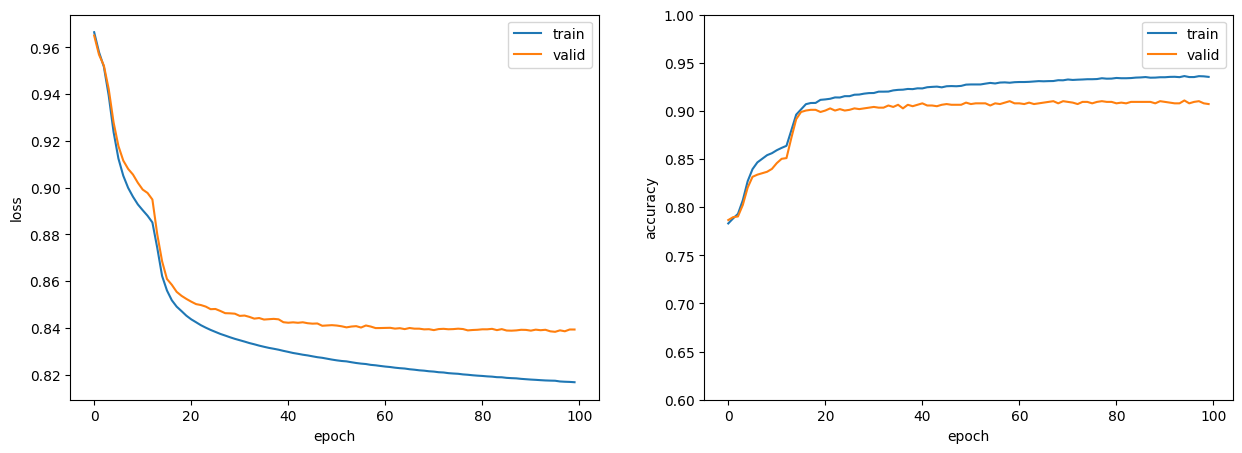

In [24]:
model = SingleLayerPerceptronNetwork(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 100

#訓練データの損失と正解率を記録
log_train = []
#検証データの損失と正解率を記録
log_valid = []

for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()

        outputs = torch.softmax(model(inputs), dim = -1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    #訓練データの損失と正解率を計算
    loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
    #検証データの損失と正解率を計算
    loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_ylim(0.6,1)
ax[1].legend()
plt.savefig("75.png")

## 76. チェックポイント

In [25]:
model = SingleLayerPerceptronNetwork(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 20

log_train = []
log_valid = []

for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for inputs, labels in dataloader_train:
        optimizer.zero_grad()

        outputs = torch.softmax(model(inputs), dim = -1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #ファイルに書き出し
    loss_train, acc_train = calc_loss_acc(model, criterion, dataloader_train)
    loss_valid, acc_valid = calc_loss_acc(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save(
        {'epoch': epoch,
         'model_state_dict': model.state_dict(), #学習途中のモデルの状態
         'optimizer_state_dict': optimizer.state_dict()}, #学習途中の最適化アルゴリズムの内部状態
         f'checkpoint{epoch + 1}.pt' #ファイルの名前
         )

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.9686, accuracy_train: 0.7818, loss_valid: 0.9673, accuracy_valid: 0.7822
epoch: 2, loss_train: 0.9590, accuracy_train: 0.7886, loss_valid: 0.9579, accuracy_valid: 0.7874
epoch: 3, loss_train: 0.9551, accuracy_train: 0.7908, loss_valid: 0.9540, accuracy_valid: 0.7889
epoch: 4, loss_train: 0.9527, accuracy_train: 0.7937, loss_valid: 0.9516, accuracy_valid: 0.7942
epoch: 5, loss_train: 0.9509, accuracy_train: 0.7941, loss_valid: 0.9498, accuracy_valid: 0.7919
epoch: 6, loss_train: 0.9496, accuracy_train: 0.7945, loss_valid: 0.9485, accuracy_valid: 0.7927
epoch: 7, loss_train: 0.9485, accuracy_train: 0.7951, loss_valid: 0.9475, accuracy_valid: 0.7934
epoch: 8, loss_train: 0.9473, accuracy_train: 0.7971, loss_valid: 0.9464, accuracy_valid: 0.7979
epoch: 9, loss_train: 0.9456, accuracy_train: 0.7977, loss_valid: 0.9449, accuracy_valid: 0.7972
epoch: 10, loss_train: 0.9379, accuracy_train: 0.8037, loss_valid: 0.9372, accuracy_valid: 0.8031
epoch: 11, loss_train: 0.9136

## 77. ミニバッチ化

In [26]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, num_epochs): #batch_sizeを受け取る。
    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        #時間を計測
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            outputs = torch.softmax(model(inputs), dim = -1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        end_time = time.time()

        loss_train, acc_train = calc_loss_acc(
            model, criterion, dataloader_train)
        loss_valid, acc_valid = calc_loss_acc(
            model, criterion, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')


In [27]:
model = SingleLayerPerceptronNetwork(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 1

for batch_size in [2 ** i for i in range(12)]:
    print(f"batch_size : {batch_size}")
    train_model(dataset_train, dataset_valid,
                batch_size, model, criterion, num_epochs)

batch_size : 1
epoch: 1, loss_train: 0.9663, accuracy_train: 0.7809, loss_valid: 0.9595, accuracy_valid: 0.7867, train_time: 5.2189sec
batch_size : 2
epoch: 1, loss_train: 0.9596, accuracy_train: 0.7864, loss_valid: 0.9532, accuracy_valid: 0.7919, train_time: 3.3966sec
batch_size : 4
epoch: 1, loss_train: 0.9564, accuracy_train: 0.7887, loss_valid: 0.9500, accuracy_valid: 0.7942, train_time: 1.4099sec
batch_size : 8
epoch: 1, loss_train: 0.9545, accuracy_train: 0.7908, loss_valid: 0.9480, accuracy_valid: 0.7949, train_time: 0.7378sec
batch_size : 16
epoch: 1, loss_train: 0.9535, accuracy_train: 0.7920, loss_valid: 0.9468, accuracy_valid: 0.7964, train_time: 0.4196sec
batch_size : 32
epoch: 1, loss_train: 0.9529, accuracy_train: 0.7926, loss_valid: 0.9462, accuracy_valid: 0.7964, train_time: 0.2528sec
batch_size : 64
epoch: 1, loss_train: 0.9526, accuracy_train: 0.7925, loss_valid: 0.9459, accuracy_valid: 0.7964, train_time: 0.1611sec
batch_size : 128
epoch: 1, loss_train: 0.9530, accur

## 78. GPU上での学習

In [33]:
def calc_loss_acc(model, criterion, loader, device):  # deviceを引数に追加
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = torch.softmax(model(inputs), dim = -1)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, num_epochs, device=None):
    model.to(device)  # deviceを引数に追加

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = model.forward(inputs)
            loss = criterion(torch.softmax(outputs, dim = -1), labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        loss_train, acc_train = calc_loss_acc(
            model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calc_loss_acc(
            model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')

    return log_train, log_valid


In [34]:
model = SingleLayerPerceptronNetwork(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 1
device = torch.device("cuda")  # deviceを指定

for batch_size in [2 ** i for i in range(12)]:
    print(f"batch_size : {batch_size}")
    train_model(dataset_train, dataset_valid,
                batch_size, model, criterion, num_epochs, device)

batch_size : 1
epoch: 1, loss_train: 0.9604, accuracy_train: 0.7869, loss_valid: 0.9598, accuracy_valid: 0.7889, train_time: 10.5048sec
batch_size : 2
epoch: 1, loss_train: 0.9445, accuracy_train: 0.8050, loss_valid: 0.9426, accuracy_valid: 0.8099, train_time: 5.0541sec
batch_size : 4
epoch: 1, loss_train: 0.9374, accuracy_train: 0.8128, loss_valid: 0.9351, accuracy_valid: 0.8204, train_time: 3.0818sec
batch_size : 8
epoch: 1, loss_train: 0.9343, accuracy_train: 0.8166, loss_valid: 0.9320, accuracy_valid: 0.8226, train_time: 1.3585sec
batch_size : 16
epoch: 1, loss_train: 0.9328, accuracy_train: 0.8180, loss_valid: 0.9306, accuracy_valid: 0.8256, train_time: 0.7506sec
batch_size : 32
epoch: 1, loss_train: 0.9321, accuracy_train: 0.8187, loss_valid: 0.9299, accuracy_valid: 0.8241, train_time: 0.3937sec
batch_size : 64
epoch: 1, loss_train: 0.9318, accuracy_train: 0.8193, loss_valid: 0.9295, accuracy_valid: 0.8241, train_time: 0.2520sec
batch_size : 128
epoch: 1, loss_train: 0.9321, accu

## 79. 多層ニューラルネットワーク

In [35]:
from torch.nn import functional as F

class MultiLayerPerceptronNetwork(nn.Module):
    def __init__(self, input_size, mid_size, output_size, mid_layers): #中間層を追加
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, output_size)
        self.bn = nn.BatchNorm1d(mid_size)

    def forward(self, x):
        x = F.relu(self.fc(x))
        for _ in range(self.mid_layers):
            x = F.relu(self.bn(self.fc_mid(x)))
        x = F.relu(self.fc_out(x))
        return x

def calc_acc(model, loader, device): # deviceを引数に追加
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  # deviceに移動
            labels = labels.to(device)  # deviceに移動
            outputs = torch.softmax(model(inputs), dim = -1)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return correct / total

epoch: 1, loss_train: 0.8753, accuracy_train: 0.8874, loss_valid: 0.8792, accuracy_valid: 0.8802, train_time: 0.7376sec
epoch: 2, loss_train: 0.8375, accuracy_train: 0.9169, loss_valid: 0.8451, accuracy_valid: 0.9019, train_time: 0.3761sec
epoch: 3, loss_train: 0.8240, accuracy_train: 0.9269, loss_valid: 0.8398, accuracy_valid: 0.9094, train_time: 0.4307sec
epoch: 4, loss_train: 0.8182, accuracy_train: 0.9320, loss_valid: 0.8412, accuracy_valid: 0.8997, train_time: 0.3469sec
epoch: 5, loss_train: 0.8121, accuracy_train: 0.9380, loss_valid: 0.8372, accuracy_valid: 0.9087, train_time: 0.3421sec
epoch: 6, loss_train: 0.8089, accuracy_train: 0.9407, loss_valid: 0.8323, accuracy_valid: 0.9124, train_time: 0.3560sec
epoch: 7, loss_train: 0.8024, accuracy_train: 0.9470, loss_valid: 0.8336, accuracy_valid: 0.9109, train_time: 0.3705sec
epoch: 8, loss_train: 0.8092, accuracy_train: 0.9401, loss_valid: 0.8448, accuracy_valid: 0.8975, train_time: 0.3521sec
epoch: 9, loss_train: 0.7949, accuracy_t

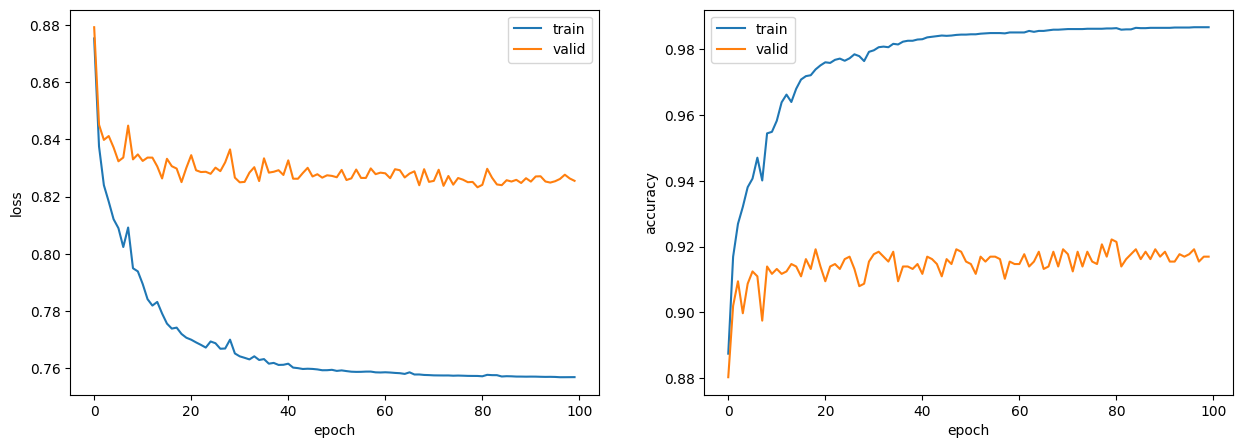

In [37]:

model = MultiLayerPerceptronNetwork(300, 200, 4, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
num_epochs = 100
device = torch.device("cuda")
batch_size = 64
log_train, log_valid = train_model(dataset_train, dataset_valid,
                                   batch_size, model, criterion, num_epochs, device)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

log_loss_train = []
log_acc_train = []
log_loss_valid = []
log_acc_valid = []

for i in range(num_epochs):
  loss_train = log_train[i][0]
  acc_train = log_train[i][1]
  loss_valid = log_valid[i][0]
  acc_valid = log_valid[i][1]
  log_loss_train.append(loss_train)
  log_acc_train.append(acc_train)
  log_loss_valid.append(loss_valid)
  log_acc_valid.append(acc_valid)

ax[0].plot(np.array(log_loss_train), label='train')
ax[0].plot(np.array(log_loss_valid), label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_acc_train), label='train')
ax[1].plot(np.array(log_acc_valid), label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.savefig("79.png")

acc_train = calc_acc(model, dataloader_train, device)
acc_test = calc_acc(model, dataloader_test, device)
print(f"train_acc : {acc_train}")
print(f"test_acc : {acc_test}")
